In [1]:
import pickle
import sys
import warnings
from collections import defaultdict
from pathlib import Path

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from src.cfd import CFD
from src.dataset import load_expanded_dataset_train_test, ExpandedDataset, X_TIME, PlaneChannel
from src.iti import build_and_train_network, build_nn_dataset, build_updated_dataset, compute_pairwise_precisions, \
    evaluate_model_wrt_cfd_average
from src.network_utils import plot_history
from src.utils import save_plt, deconvolve_precisions

PWD = '../../..'
sys.path.append(PWD)

warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

DIR_NAME = 'iti_train'
ARTIFACT_DIR = Path(PWD) / Path('data/iti/train/')

In [2]:
BASE_CFD_THRESHOLD = 0.2
CFD_N_BASELINE = 6

base_cfd = CFD(n_baseline=CFD_N_BASELINE, threshold=BASE_CFD_THRESHOLD)

In [3]:
OVERWRITE = False

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 1000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

LR_PATIENCE = 5
ES_PATIENCE = 50

VERBOSE = 0

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [4]:
base_dataset, _ = load_expanded_dataset_train_test(PWD)

In [5]:
train_idx, val_idx = train_test_split(np.arange(len(base_dataset)), test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_dataset = base_dataset.extract_by_idx(train_idx)
val_dataset = base_dataset.extract_by_idx(val_idx)

x_train, y_train_t, y_train = build_nn_dataset(train_dataset)
x_val, y_val_t, y_val = build_nn_dataset(val_dataset)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((80157, 24), (20040, 24), (80157, 24), (20040, 24))

# Utils

In [6]:
def try_load_dataset(i_it: int, overwrite: bool = OVERWRITE) -> ExpandedDataset | None:
    if overwrite:
        return None
    dataset_path = ARTIFACT_DIR / 'dataset' / f"it_{i_it}"
    if not dataset_path.is_file():
        return None
    else:
        with open(dataset_path, 'rb') as file:
            return pickle.load(file)


def save_dataset(i_it: int, dataset: ExpandedDataset) -> None:
    dataset_dir = ARTIFACT_DIR / 'dataset'
    dataset_dir.mkdir(parents=True, exist_ok=True)
    dataset_path = dataset_dir / f"it_{i_it}"
    with open(dataset_path, 'wb') as file:
        pickle.dump(dataset, file)


def plot_precisions(precision_dict: dict, title: str) -> None:
    it_pairwise_prec_by_channel = defaultdict(list)
    for it, prec_dict_it in precision_dict.items():
        for p_ch_pair, prec in prec_dict_it.items():
            it_pairwise_prec_by_channel[p_ch_pair].append(prec)

    plt.figure(figsize=(7, 4))
    for p_ch_pair, prec in it_pairwise_prec_by_channel.items():
        plt.plot(np.arange(len(prec)), prec, marker='.', label=str(p_ch_pair))

    plt.xticks(list(precision_dict.keys()))
    plt.title(f'{title} by iteration')
    plt.xlabel('Iteration')
    plt.ylabel(f'{title} [ps]')
    plt.grid()
    plt.legend()
    plt.show()

    avg_pairwise_prec_by_channel = {it: np.mean(list(data.values())) for it, data in precision_dict.items()}

    plt.figure(figsize=(7, 4))
    plt.plot(avg_pairwise_prec_by_channel.keys(), avg_pairwise_prec_by_channel.values(), marker='.')
    plt.xticks(list(avg_pairwise_prec_by_channel.keys()))
    plt.title(f'Average {title} by iteration')
    plt.xlabel('Iteration')
    plt.ylabel(f'Average {title} [ps]')
    plt.grid()
    plt.show()


def plot_graph(data: dict[PlaneChannel, float], title: str, ylabel: str, xlabel: str = 'Iteration'):
    plt.figure(figsize=(7, 4))
    plt.plot(data.keys(), data.values(), marker='.')
    plt.xticks(list(data.keys()))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

# Init

In [7]:
loss_by_it = {}
cfd_ref_precisions_by_it = {}
cfd_ref_diff_means_by_it = {}
pairwise_precisions_stat_by_it = {}
pairwise_precisions_gauss_by_it = {}
deconvolved_precisions_stat_by_it = {}
deconvolved_precisions_gauss_by_it = {}
val_t_pred_by_it = {}
val_dataset_by_it = {0: val_dataset}

In [8]:
pairwise_precisions_stat, pairwise_precisions_gauss = compute_pairwise_precisions(val_dataset)
pairwise_precisions_stat_by_it[0] = pairwise_precisions_stat
pairwise_precisions_gauss_by_it[0] = pairwise_precisions_gauss

deconvolved_precisions_stat_by_it[0] = deconvolve_precisions(pairwise_precisions_stat)
deconvolved_precisions_gauss_by_it[0] = deconvolve_precisions(pairwise_precisions_gauss)

# Train

In [9]:
N_ITER = 20

In [10]:
base_dataset_it = base_dataset

x_train_it = x_train
x_val_it = x_val
y_train_it = y_train
y_val_it = y_val

for i_it in range(1, N_ITER + 1):
    print(f'========== ITERATION {i_it}/{N_ITER} ==========')
    print('--> Step 1. Training model...')
    model, history = build_and_train_network(iteration=i_it, x_train=x_train_it, x_val=x_val_it, y_train=y_train_it,
                                             y_val=y_val_it, overwrite=OVERWRITE, pwd=PWD, dir_name=DIR_NAME, lr=LR,
                                             n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, lr_patience=LR_PATIENCE,
                                             es_patience=ES_PATIENCE, es_min_delta=ES_MIN_DELTA,
                                             loss_weight=LOSS_WEIGHT, verbose=VERBOSE)
    loss_by_it[i_it] = min(history['val_loss'])
    plot_history(history, ymax=20, show=False, title=f'loss curve; it {i_it}')
    save_plt(ARTIFACT_DIR / 'loss_curve' / f'it_{i_it}')
    plt.close()
    print(f'Trained. Loss: {loss_by_it[i_it]:0.3f}')

    print('--> Step 2. Evaluating precision wrt the CFD averages')
    mu, std = evaluate_model_wrt_cfd_average(model, x_val, y_val_t, BATCH_SIZE,
                                             hist_path=ARTIFACT_DIR / 'diff_hist_wrt_cfd_avg' / f'it_{i_it}')
    cfd_ref_precisions_by_it[i_it] = std
    cfd_ref_diff_means_by_it[i_it] = mu

    print('--> Step 3. Updating dataset...')
    loaded_dataset = try_load_dataset(i_it)
    if loaded_dataset is not None:
        print('Loaded the dataset')
        base_dataset_it = loaded_dataset
    else:
        base_dataset_it = build_updated_dataset(
            model, base_dataset_it, BATCH_SIZE, log=False,
            global_t_pred_hists_path=ARTIFACT_DIR / 'global_t_pred' / f'it_{i_it}'
        )
        save_dataset(i_it, base_dataset_it)
        print('Saved the dataset')

    train_dataset_it = base_dataset_it.extract_by_idx(train_idx)
    val_dataset_it = base_dataset_it.extract_by_idx(val_idx)
    val_dataset_by_it[i_it] = val_dataset_it

    x_train_it, y_train_t_it, y_train_it = build_nn_dataset(train_dataset_it)
    x_val_it, y_val_t_it, y_val_it = build_nn_dataset(val_dataset_it)

    # t pred histograms to validate potential mode collapse
    plt.hist(y_val_t_it, bins=100, range=(0, 3.))
    save_plt(ARTIFACT_DIR / 't_pred_hist' / f'it_{i_it}')
    plt.close()

    print('--> Step 4. Evaluating pairwise precision...')
    pairwise_precisions_stat, pairwise_precisions_gauss = compute_pairwise_precisions(
        val_dataset_it, hists_path=ARTIFACT_DIR / 'pairwise_diff_hists' / f'it_{i_it}'
    )
    pairwise_precisions_stat_by_it[i_it] = pairwise_precisions_stat
    pairwise_precisions_gauss_by_it[i_it] = pairwise_precisions_gauss

    deconvolved_precisions_stat_by_it[i_it] = deconvolve_precisions(pairwise_precisions_stat)
    deconvolved_precisions_gauss_by_it[i_it] = deconvolve_precisions(pairwise_precisions_gauss)

    avg_prec_stat = np.average(list(pairwise_precisions_stat.values()))
    avg_prec_gauss = np.average(list(pairwise_precisions_gauss.values()))
    print(f"Average precision; stat: {avg_prec_stat:6.2f} ps; Gauss {avg_prec_gauss:6.2f} ps")

========== ITERATION 1/20 ==========
--> Step 1. Training model...
Trained. Loss: 12.349
--> Step 2. Evaluating precision wrt the CFD averages
3/3 [==============================] - 2s 30ms/step
--> Step 3. Updating dataset...
Loaded the dataset
--> Step 4. Evaluating pairwise precision...
Average precision; stat:  92.34 ps; Gauss  81.00 ps
========== ITERATION 2/20 ==========
--> Step 1. Training model...
Trained. Loss: 10.565
--> Step 2. Evaluating precision wrt the CFD averages
3/3 [==============================] - 0s 16ms/step
--> Step 3. Updating dataset...
Loaded the dataset
--> Step 4. Evaluating pairwise precision...
Average precision; stat:  89.51 ps; Gauss  78.53 ps
========== ITERATION 3/20 ==========
--> Step 1. Training model...
Trained. Loss: 10.245
--> Step 2. Evaluating precision wrt the CFD averages
3/3 [==============================] - 0s 145ms/step
--> Step 3. Updating dataset...
Loaded the dataset
--> Step 4. Evaluating pairwise precision...
Average precision; sta

# Analyse

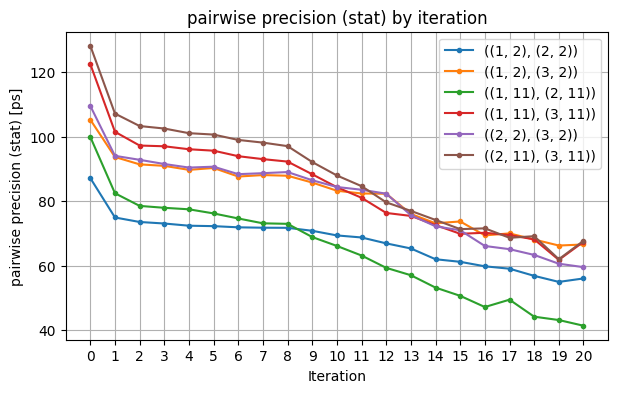

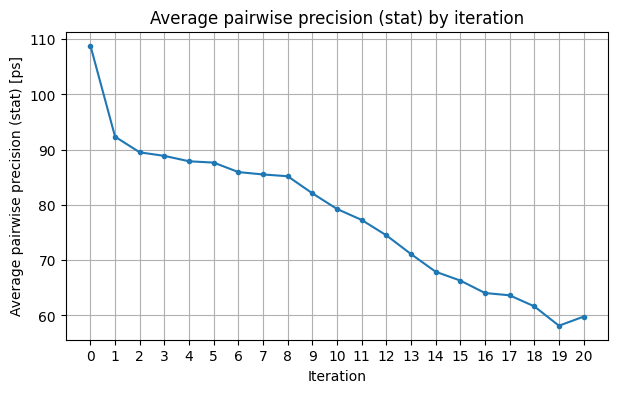

In [11]:
plot_precisions(pairwise_precisions_stat_by_it, "pairwise precision (stat)")

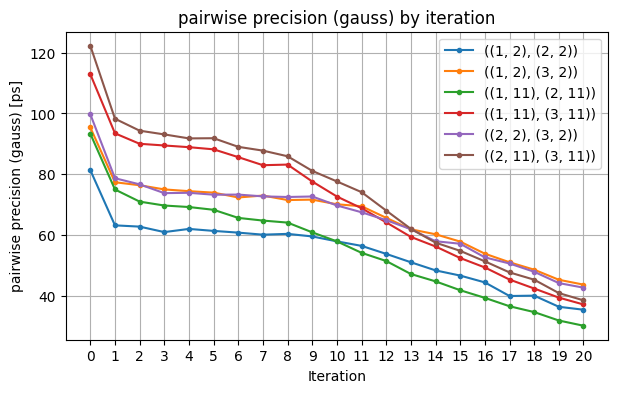

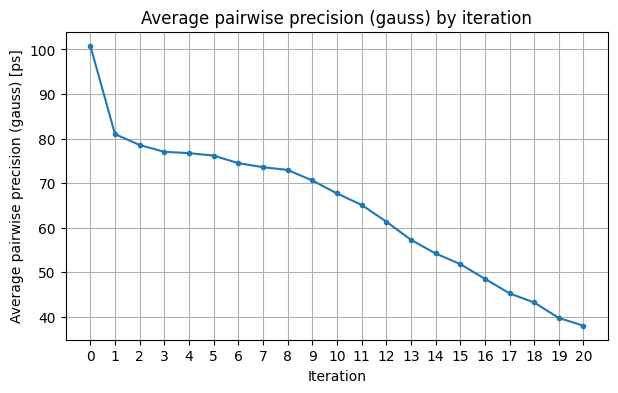

In [12]:
plot_precisions(pairwise_precisions_gauss_by_it, "pairwise precision (gauss)")

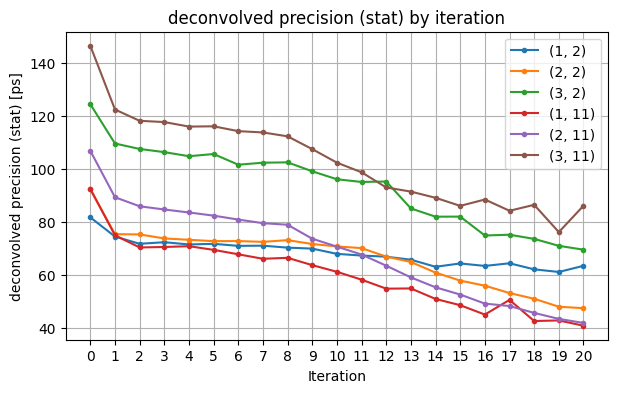

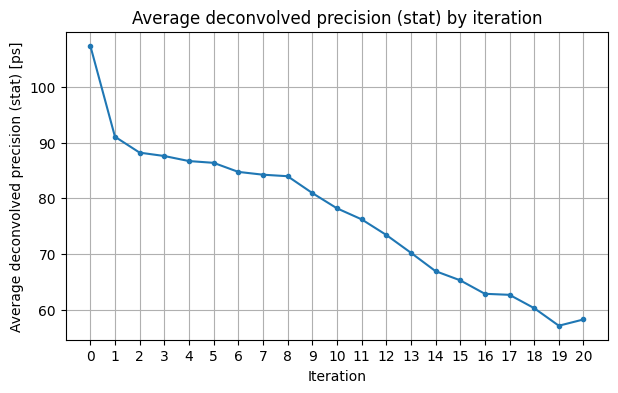

In [13]:
plot_precisions(deconvolved_precisions_stat_by_it, "deconvolved precision (stat)")

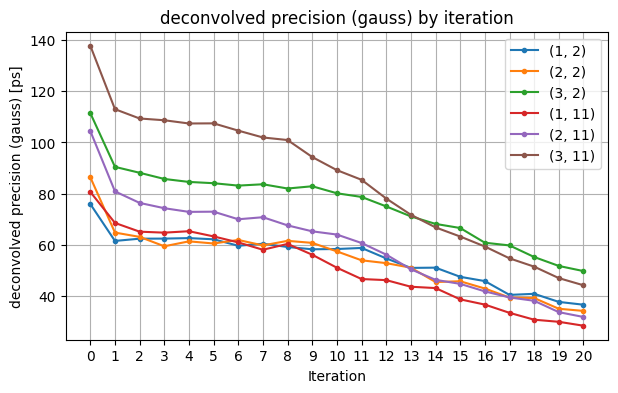

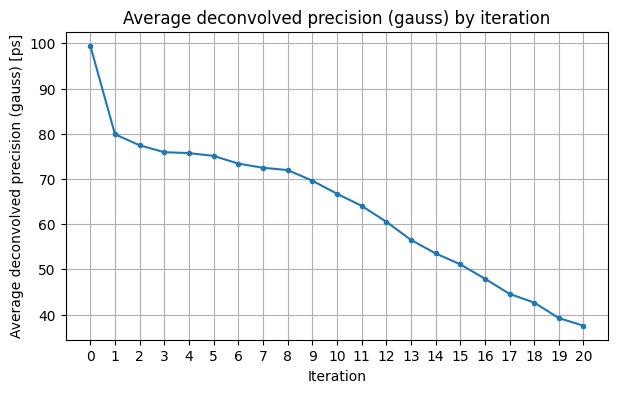

In [14]:
plot_precisions(deconvolved_precisions_gauss_by_it, "deconvolved precision (gauss)")

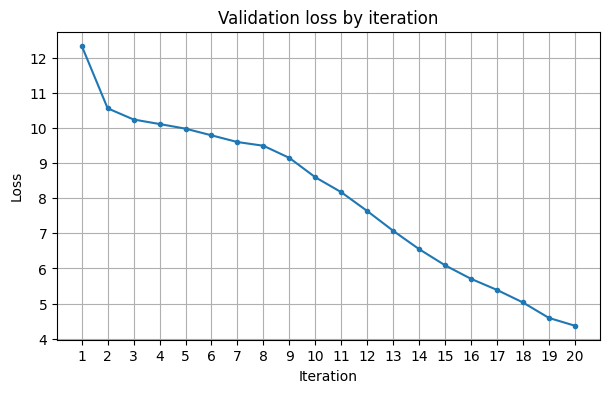

In [15]:
plot_graph(loss_by_it, 'Validation loss by iteration', 'Loss')

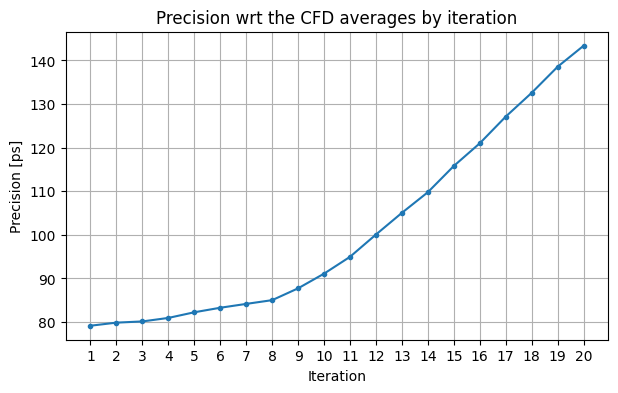

In [16]:
plot_graph(cfd_ref_precisions_by_it, 'Precision wrt the CFD averages by iteration', 'Precision [ps]')

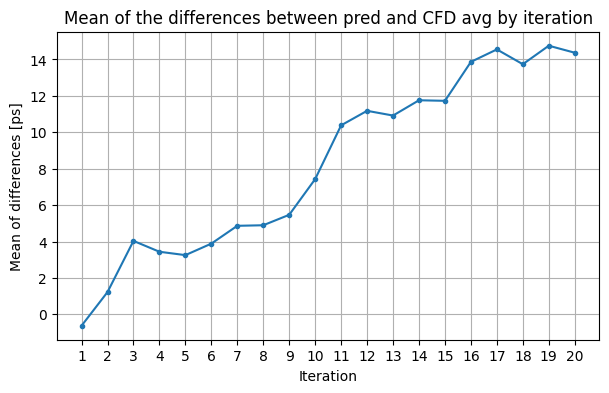

In [17]:
plot_graph(cfd_ref_diff_means_by_it, 'Mean of the differences between pred and CFD avg by iteration',
           'Mean of differences [ps]')

# Examples

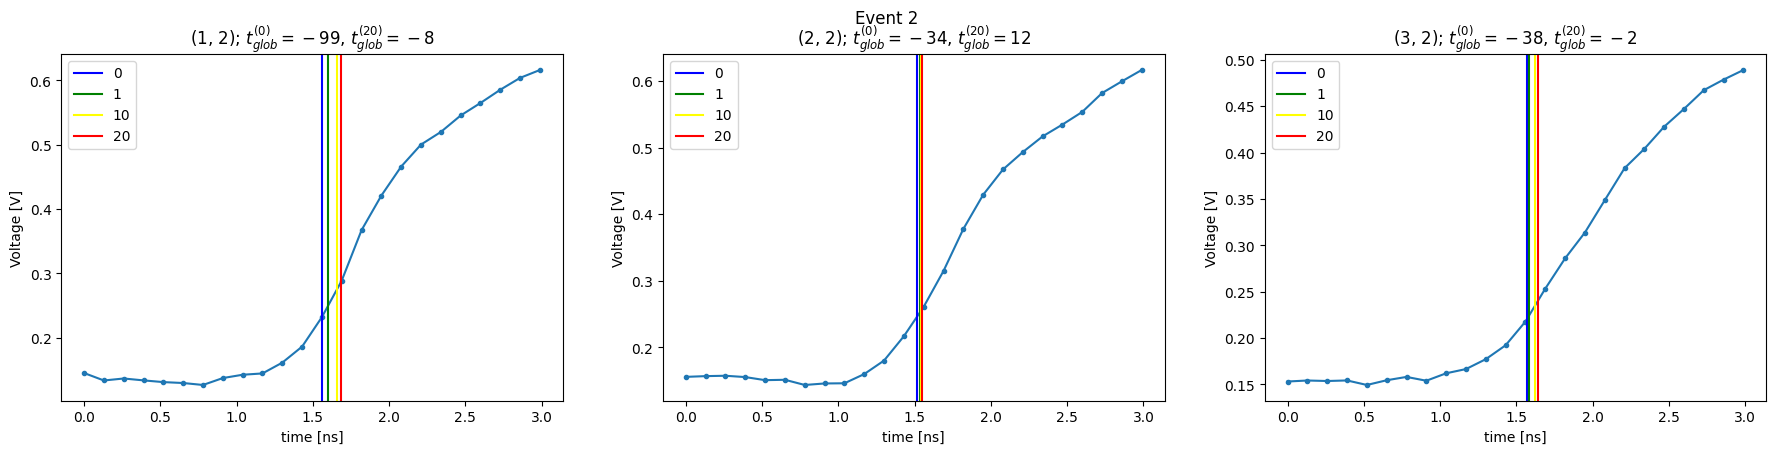

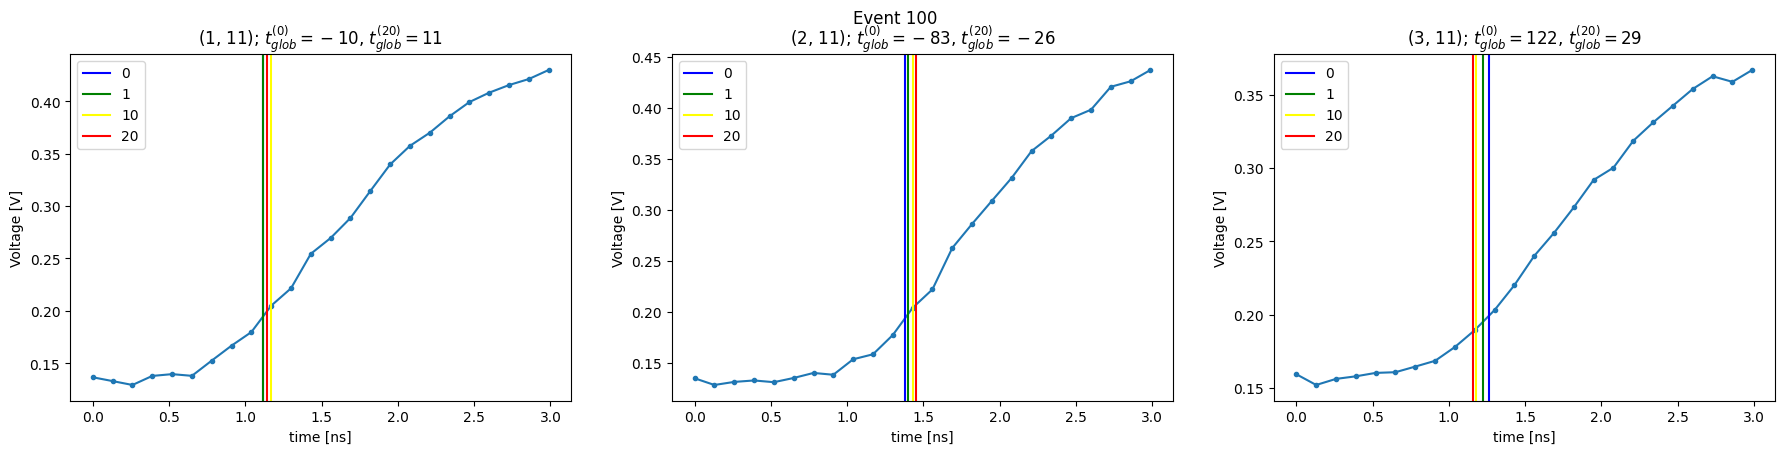

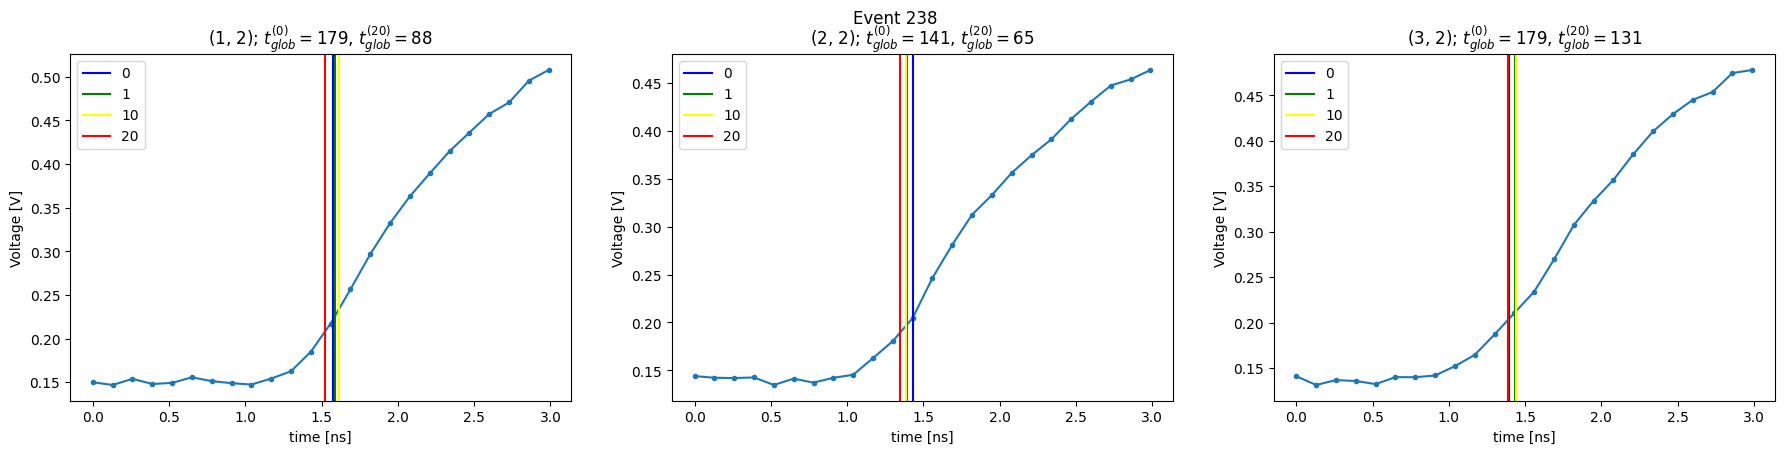

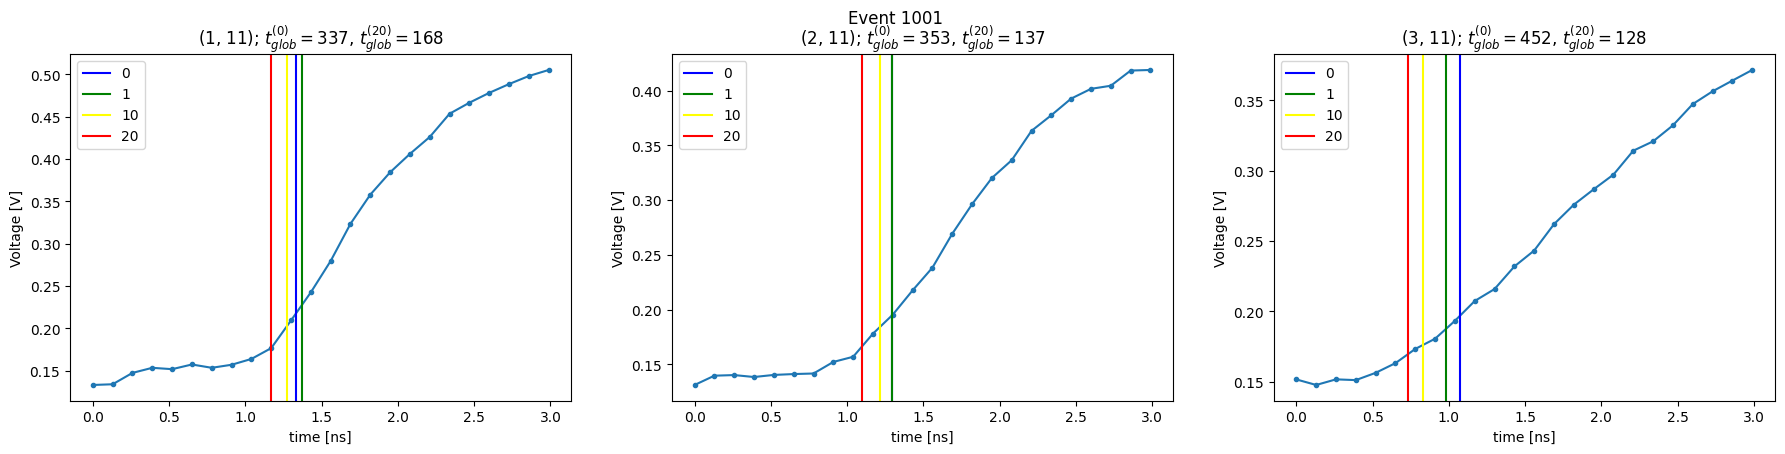

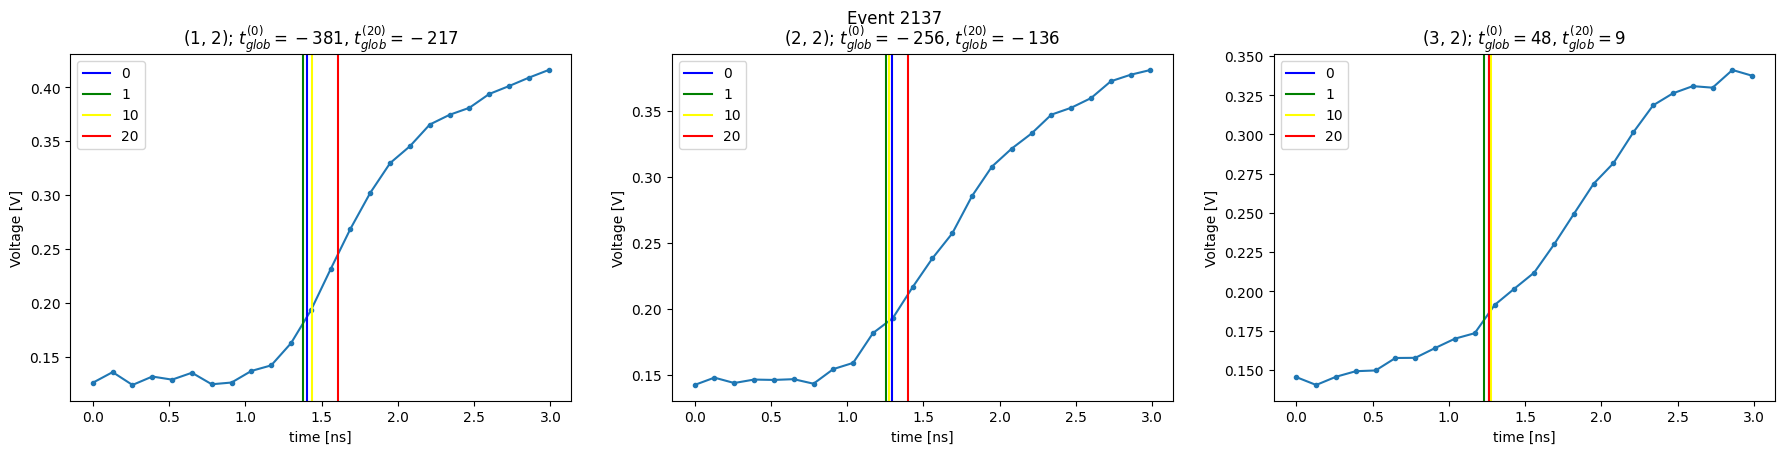

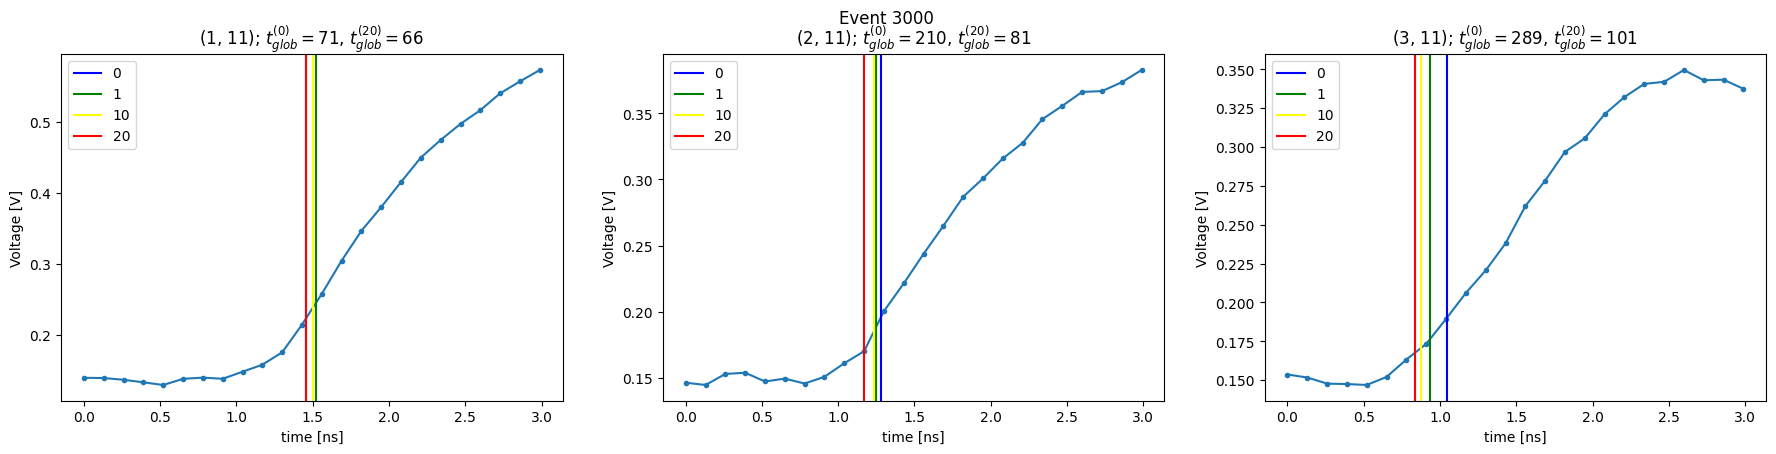

In [18]:
idx_list = [2, 100, 238, 1001, 2137, 3000]

for idx in idx_list:
    plt.figure(figsize=(22, 4.5))
    i_subplot = 1
    for p_ch, data in val_dataset.wav.items():
        if not val_dataset.notnan_mask[p_ch][idx]:
            continue
        plt.subplot(1, 3, i_subplot)
        i_subplot += 1
        plt.plot(X_TIME, data[idx], marker='.')
        cmap = ['blue', 'green', 'yellow', 'red']
        i_it_list = [0, 1, N_ITER // 2, N_ITER]
        for i, i_it in enumerate(i_it_list):
            dataset = val_dataset_by_it[i_it]
            plt.axvline(dataset.t_pred[p_ch][idx], label=i_it, c=cmap[i % len(cmap)])
        t_global_0 = val_dataset.t0[p_ch][idx] + val_dataset.t_pred[p_ch][idx]
        t_global_final = val_dataset_by_it[N_ITER].t0[p_ch][idx] + val_dataset_by_it[N_ITER].t_pred[p_ch][idx]
        plt.title(f"{p_ch}; $t_{{glob}}^{{(0)}} = {t_global_0 * 1000:0.0f}$, $t_{{glob}}^{{({N_ITER})}} = {t_global_final * 1000:0.0f}$")
        plt.xlabel('time [ns]')
        plt.ylabel('Voltage [V]')
        plt.legend()
    plt.suptitle(f'Event {idx}')
    plt.show()